Running 11 umbrella sampling windows...
  Window 1/11 centered at x = -1.50
    Acceptance rate: 0.713
  Window 2/11 centered at x = -1.20
    Acceptance rate: 0.731
  Window 3/11 centered at x = -0.90
    Acceptance rate: 0.746
  Window 4/11 centered at x = -0.60
    Acceptance rate: 0.779
  Window 5/11 centered at x = -0.30
    Acceptance rate: 0.789
  Window 6/11 centered at x = 0.00
    Acceptance rate: 0.802
  Window 7/11 centered at x = 0.30
    Acceptance rate: 0.792
  Window 8/11 centered at x = 0.60
    Acceptance rate: 0.780
  Window 9/11 centered at x = 0.90
    Acceptance rate: 0.753
  Window 10/11 centered at x = 1.20
    Acceptance rate: 0.729
  Window 11/11 centered at x = 1.50
    Acceptance rate: 0.711
Simulations finished.
Unbiasing histograms...
Combining PMFs...
Plotting results...


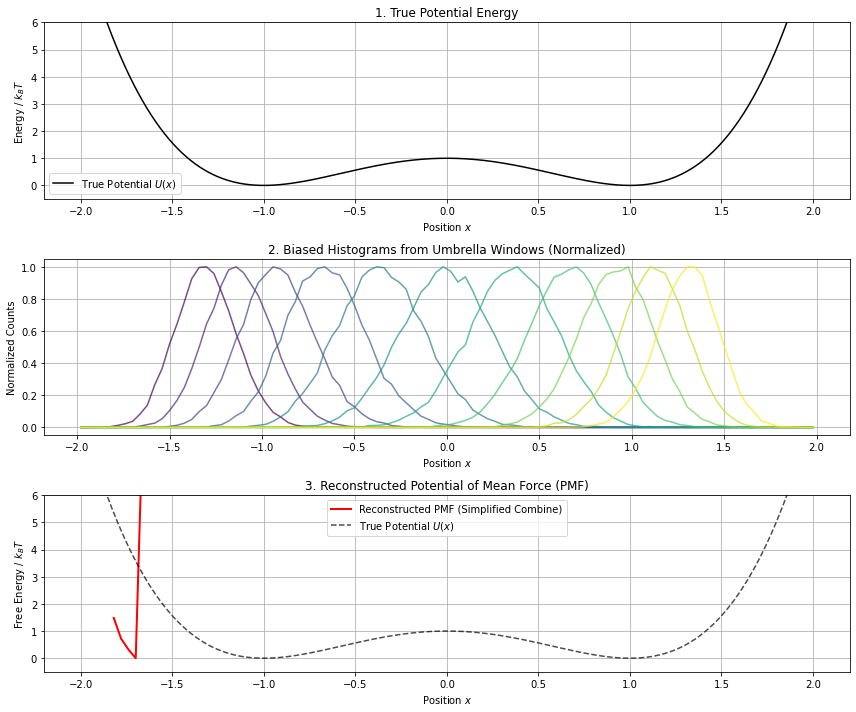

Done.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random

# --- 1. Define System and Potential ---
def potential_energy(x):
  """
  A simple double-well potential creating a barrier at x=0.
  U(x) = amplitude * (x^2 - well_pos^2)^2
  Minima at +/- well_pos, barrier height related to amplitude.
  """
  amplitude = 10.0  # Controls barrier height
  well_pos = 1.0   # Position of the potential wells
  return amplitude * (x**2 - well_pos**2)**2

def bias_potential(x, center, k):
  """Harmonic umbrella potential."""
  return 0.5 * k * (x - center)**2

# --- 2. Simulation Parameters ---
kT = 1.0                # Thermal energy (Boltzmann constant * Temperature)
n_windows = 15          # Number of umbrella windows
window_centers = np.linspace(-1.5, 1.5, n_windows) # Centers for the bias potentials
k_umbrella = 20.0       # Force constant for the umbrella potential

n_steps = 50000         # Monte Carlo steps per window
n_equilibration = 5000  # Steps to discard for equilibration
mc_step_size = 0.5      # Maximum displacement for a Monte Carlo move

# Histogram parameters
hist_min = -2.0
hist_max = 2.0
n_bins = 100
hist_bins = np.linspace(hist_min, hist_max, n_bins + 1)
bin_centers = (hist_bins[:-1] + hist_bins[1:]) / 2.0

# --- 3. Run Monte Carlo for Each Window ---
all_positions = [] # Store position data for each window
biased_histograms = [] # Store biased histograms

print(f"Running {n_windows} umbrella sampling windows...")

for i, center in enumerate(window_centers):
  print(f"  Window {i+1}/{n_windows} centered at x = {center:.2f}")
  positions = []
  # Start near the window center
  current_x = center + (random.random() - 0.5) * 0.1

  # Calculate initial total energy (physical + bias)
  current_U_physical = potential_energy(current_x)
  current_U_bias = bias_potential(current_x, center, k_umbrella)
  current_U_total = current_U_physical + current_U_bias

  n_accepted = 0
  for step in range(n_steps + n_equilibration):
    # Propose a move
    trial_x = current_x + (random.random() - 0.5) * mc_step_size

    # Calculate new energy
    trial_U_physical = potential_energy(trial_x)
    trial_U_bias = bias_potential(trial_x, center, k_umbrella)
    trial_U_total = trial_U_physical + trial_U_bias

    # Metropolis acceptance criterion
    delta_U = trial_U_total - current_U_total
    accept = False
    if delta_U < 0:
      accept = True
    else:
      prob = math.exp(-delta_U / kT)
      if random.random() < prob:
        accept = True

    if accept:
      current_x = trial_x
      current_U_total = trial_U_total
      if step >= n_equilibration:
        n_accepted += 1

    # Record position after equilibration phase
    if step >= n_equilibration:
      positions.append(current_x)

  all_positions.append(np.array(positions))
  acceptance_rate = n_accepted / n_steps
  print(f"    Acceptance rate: {acceptance_rate:.3f}")

  # Create histogram for this window
  hist, _ = np.histogram(positions, bins=hist_bins, density=False)
  biased_histograms.append(hist)

print("Simulations finished.")

# --- 4. Unbias and Combine Histograms (Simplified WHAM concept) ---
unbiased_histograms = []
window_pmfs = [] # Store PMF calculated from each window

print("Unbiasing histograms...")
for i, hist in enumerate(biased_histograms):
  center = window_centers[i]
  # Calculate the bias energy at the center of each bin
  bias_energies_at_bins = bias_potential(bin_centers, center, k_umbrella)
  # Unbiasing factor: exp(+U_bias / kT)
  unbias_factors = np.exp(bias_energies_at_bins / kT)

  # Multiply histogram counts by the unbiasing factor
  # Add a small value to avoid log(0) later
  unbiased_hist = hist * unbias_factors + 1e-10
  unbiased_histograms.append(unbiased_hist)

  # Calculate PMF for this window (up to an additive constant)
  # PMF = -kT * log(Probability), Probability ~ histogram count
  pmf = -kT * np.log(unbiased_hist)
  window_pmfs.append(pmf)

# --- 5. Combine PMFs (Simple Vertical Shifting) ---
# This is a simplified way to combine, real WHAM is more robust.
# We shift each PMF segment vertically to match the previous one in the overlap region.

print("Combining PMFs...")
combined_pmf = np.zeros_like(bin_centers) * np.nan # Initialize with NaN
shift = 0.0 # Initial shift for the first window PMF

# Set the first window's PMF as the starting point, shifted so its minimum is 0
min_val_first_win = np.min(window_pmfs[0])
window_pmfs[0] -= min_val_first_win # Shift first PMF

# Iteratively shift subsequent PMFs
for i in range(n_windows):
    current_pmf = window_pmfs[i] + shift

    # Add the relevant part of the current PMF to the combined PMF
    # Use points where the histogram count was non-negligible (e.g., > 1% of max)
    valid_indices = np.where(biased_histograms[i] > 0.01 * np.max(biased_histograms[i]))[0]
    if len(valid_indices) > 0:
        # Handle edge cases for indices
        start_idx = max(0, valid_indices[0] -1) # Extend slightly for overlap check
        end_idx = min(n_bins, valid_indices[-1] + 2)

        # Naive averaging in overlap: just overwrite for simplicity here
        # A better method would average or use WHAM weights
        combined_pmf[start_idx:end_idx] = current_pmf[start_idx:end_idx]


    # Calculate shift for the *next* window (if not the last one)
    if i < n_windows - 1:
        next_pmf = window_pmfs[i+1]
        # Find overlapping bins (where both histograms have counts)
        overlap_indices = np.where((biased_histograms[i] > 1) & (biased_histograms[i+1] > 1))[0]

        if len(overlap_indices) > 1:
            # Calculate the average difference in the overlap region
            diff = (current_pmf[overlap_indices] - (next_pmf[overlap_indices])) # Shift applied to current_pmf already
            shift_increment = np.mean(diff)
            shift = shift_increment # The next PMF needs to be shifted by this amount
            # Shift the reference PMF itself for the next iteration's calculation
            window_pmfs[i+1] += shift
        else:
             # If no good overlap, try a simpler shift based on window centers? Risky.
             # Or just stop combining (results in gaps)
             print(f"Warning: Poor overlap between window {i} and {i+1}. Combining might be inaccurate.")
             # Heuristic: Try to align based on the last point of current and first point of next
             if len(valid_indices)>0 and len(np.where(biased_histograms[i+1] > 1)[0]) >0:
                  last_idx_curr = valid_indices[-1]
                  first_idx_next = np.where(biased_histograms[i+1] > 1)[0][0]
                  if first_idx_next < len(current_pmf):
                     shift = current_pmf[last_idx_curr] - next_pmf[first_idx_next]
                     window_pmfs[i+1] += shift
                  else:
                     shift = 0 # fallback
             else:
                  shift = 0 # fallback


# Final shift so the minimum of the combined PMF is 0
min_pmf_val = np.nanmin(combined_pmf)
if not np.isnan(min_pmf_val):
    combined_pmf -= min_pmf_val
else:
    print("Warning: Combined PMF contains only NaNs.")


# --- 6. Plotting ---
print("Plotting results...")
plt.figure(figsize=(12, 10))

# Plot 1: Original Potential
plt.subplot(3, 1, 1)
x_fine = np.linspace(hist_min, hist_max, 500)
plt.plot(x_fine, potential_energy(x_fine), 'k-', label='True Potential $U(x)$')
plt.title('1. True Potential Energy')
plt.xlabel('Position $x$')
plt.ylabel('Energy / $k_BT$')
plt.ylim(min(potential_energy(x_fine))-0.5, potential_energy(0) + kT*5) # Adjust ylim
plt.legend()
plt.grid(True)

# Plot 2: Biased Histograms
plt.subplot(3, 1, 2)
colors = plt.cm.viridis(np.linspace(0, 1, n_windows))
for i in range(n_windows):
  # Normalize height for visual clarity
  max_h = np.max(biased_histograms[i])
  if max_h > 0:
      plt.plot(bin_centers, biased_histograms[i] / max_h, color=colors[i], alpha=0.7, label=f'Win {i+1} ({window_centers[i]:.1f})')
  else:
      plt.plot([],[], color=colors[i], alpha=0.7, label=f'Win {i+1} ({window_centers[i]:.1f})') # Plot empty if no counts

plt.title('2. Biased Histograms from Umbrella Windows (Normalized)')
plt.xlabel('Position $x$')
plt.ylabel('Normalized Counts')
# plt.legend(ncol=2, fontsize='small') # Legend can get crowded
plt.grid(True)


# Plot 3: Reconstructed PMF
plt.subplot(3, 1, 3)
# Plot individual unbiased PMFs shifted
# for i in range(n_windows):
#     pmf_shifted = window_pmfs[i] # Already shifted during combination
#     valid_indices = np.where(biased_histograms[i] > 1)[0] # Only plot where we had data
#     if len(valid_indices) > 0:
#       plt.plot(bin_centers[valid_indices], pmf_shifted[valid_indices], color=colors[i], alpha=0.3, linestyle=':')


# Plot the combined PMF
plt.plot(bin_centers, combined_pmf, 'r-', linewidth=2, label='Reconstructed PMF (Simplified Combine)')
# Plot the true potential again for comparison
plt.plot(x_fine, potential_energy(x_fine), 'k--', alpha=0.7, label='True Potential $U(x)$')

plt.title('3. Reconstructed Potential of Mean Force (PMF)')
plt.xlabel('Position $x$')
plt.ylabel('Free Energy / $k_BT$')
plt.ylim(min(potential_energy(x_fine))-0.5, potential_energy(0) + kT*5) # Match ylim with plot 1
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("Done.")